<a href="https://colab.research.google.com/github/nbeeeel/Depth-Nerf/blob/main/Depth_Nerf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Installing Requisites**





In [ ]:
!pip install imageio-ffmpeg

#**Importing Packages**

In [ ]:
import os, sys
import tensorflow as tf
import glob
import matplotlib.image as mpimg
import imageio
import zipfile
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

#**Defining Parameters**

In [ ]:
tf.random.set_seed(42)
# Initialize global variables.
AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 2
NUM_SAMPLES = 4
POS_ENCODE_DIMS = 16
EPOCHS = 20

#**Cloning the Redwood 3d-scan repo**

In [ ]:
!git clone https://github.com/isl-org/redwood-3dscan

Cloning into 'redwood-3dscan'...
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 17 (delta 4), reused 14 (delta 2), pack-reused 0
Receiving objects: 100% (17/17), 175.34 KiB | 3.81 MiB/s, done.
Resolving deltas: 100% (4/4), done.


In [ ]:
%cd /content/redwood-3dscan

/content/redwood-3dscan


#**Importing Util and Sofa Class From the Dataset**

In [ ]:
import redwood_3dscan as rws

In [ ]:
# # Print RGBD scans (list)
# print(rws.rgbds)

# # Print meshes (list)
# print(rws.meshes)

# # Print categories (dict: string->list)
# print(rws.categories)

# # Print all scan_id of the "sofa" category
# print(rws.categories["sofa"])

# Download by scan_id "00033"
# Download will be skipped if the resource is unavailable
# e.g. some RGBD images may not come with mesh.
rws.download_rgbd("00033")  # Save to data/rgbd/00033.zip, if available
rws.download_mesh("00033")  # Save to data/mesh/00033.ply, if available
rws.download_video("00033") # Save to data/video/00033.mp4, if available
# rws.download_all("05668")   # Downloads rgbd, mesh, and video together
# rws.download_all("05669")
# rws.download_all("05671")
# Download by category "sofa"
# rws.download_category("candle")

/content/redwood-3dscan/data/rgbd/00033.zip already exists. Skipped.
/content/redwood-3dscan/data/mesh/00033.ply already exists. Skipped.
/content/redwood-3dscan/data/video/00033.mp4 already exists. Skipped.


In [ ]:
zip_directory = '/content/redwood-3dscan/rgb'  # Replace with the actual path
zip_file_paths = glob.glob(os.path.join(zip_directory, '*.jpg'))

In [ ]:
zip_file_paths = sorted(zip_file_paths)

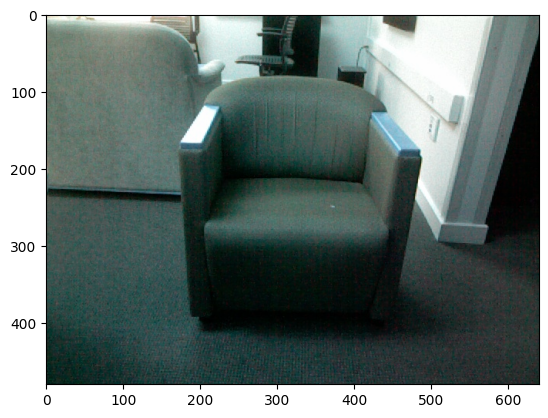

In [ ]:
plt.imshow(cv2.imread(zip_file_paths[0]))

#**Extracting the Pose Matrix**

In [ ]:
import numpy as np

# Define camera parameters
focal_length = 525.0
principal_point_x = 319.5
principal_point_y = 239.5

# Create the camera matrix K
K = np.array([
    [focal_length, 0, principal_point_x],
    [0, focal_length, principal_point_y],
    [0, 0, 1]
])

# Define small variations for rotation and translation
rotation_variation = 0.1  # Adjust as needed
translation_variation = 0.05  # Adjust as needed

# Create the identity rotation matrix
R = np.eye(3)

# Create the initial translation vector (assuming fixed depth)
t = np.array([0, 0, 1.0])  # Fixed depth of 1.0

# Create a list to store 4x4 pose matrices for all 1877 images
num_images = 1877
pose_matrices_4x4 = []

# Generate pose matrices with slight variations
for _ in range(num_images):
    # Add small random variations to the translation vector
    t_variation = np.random.uniform(-translation_variation, translation_variation, size=(3,))
    t_with_variation = t + t_variation

    # Create the 4x4 pose matrix with variations and perspective division
    pose_matrix_4x4 = np.vstack((np.hstack((R, t_with_variation.reshape(-1, 1))), [0, 0, 0, 1]))

    pose_matrices_4x4.append(pose_matrix_4x4)


In [ ]:
pose_matrices_4x4 = pose_matrices_4x4[:100]

In [ ]:
poses = np.asarray(pose_matrices_4x4)

In [ ]:
images1=zip_file_paths[:100]

In [ ]:
images = []
for i in images1:
  img = cv2.imread(i)
  img = cv2.resize(img,(100,100))
  images.append(img)

In [ ]:
images=np.asarray(images)

In [ ]:
images.shape

(100, 100, 100, 3)

In [ ]:
focal = 525.0

In [ ]:
images11 =[]
for img in images:
  img1 = img/255.0
  images11.append(img1)

In [ ]:
images11=np.asarray(images11)

In [ ]:
images11 = tf.cast(images11,tf.float32)

In [ ]:
images = images11

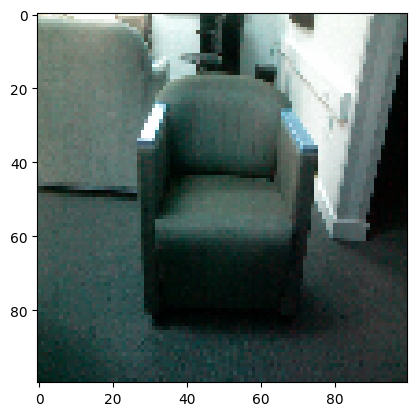

In [ ]:
plt.imshow(images[1])

In [ ]:
poses = poses.astype(np.float32)

In [ ]:
H,W,C = images.shape[1],images.shape[2],images.shape[3]

#**Preprocessing**

In [ ]:
def encode_position(x):
    """Encodes the position into its corresponding Fourier feature.

    Args:
        x: The input coordinate.

    Returns:
        Fourier features tensors of the position.
    """
    positions = [x]
    for i in range(POS_ENCODE_DIMS):
        for fn in [tf.sin, tf.cos]:
            positions.append(fn(2.0 ** i * x))
    return tf.concat(positions, axis=-1)


def get_rays(height, width, focal, pose):
    """Computes origin point and direction vector of rays.

    Args:
        height: Height of the image.
        width: Width of the image.
        focal: The focal length between the images and the camera.
        pose: The pose matrix of the camera.

    Returns:
        Tuple of origin point and direction vector for rays.
    """
    # Build a meshgrid for the rays.
    i, j = tf.meshgrid(
        tf.range(width, dtype=tf.float32),
        tf.range(height, dtype=tf.float32),
        indexing="xy",
    )

    # Normalize the x axis coordinates.
    transformed_i = (i - width * 0.5) / focal

    # Normalize the y axis coordinates.
    transformed_j = (j - height * 0.5) / focal

    # Create the direction unit vectors.
    directions = tf.stack([transformed_i, -transformed_j, -tf.ones_like(i)], axis=-1)

    # Get the camera matrix.
    camera_matrix = pose[:3, :3]
    height_width_focal = pose[:3, -1]

    # Get origins and directions for the rays.
    transformed_dirs = directions[..., None, :]
    camera_dirs = transformed_dirs * camera_matrix
    ray_directions = tf.reduce_sum(camera_dirs, axis=-1)
    ray_origins = tf.broadcast_to(height_width_focal, tf.shape(ray_directions))

    # Return the origins and directions.
    return (ray_origins, ray_directions)


def render_flat_rays(ray_origins, ray_directions, near, far, num_samples, rand=False):
    """Renders the rays and flattens it.

    Args:
        ray_origins: The origin points for rays.
        ray_directions: The direction unit vectors for the rays.
        near: The near bound of the volumetric scene.
        far: The far bound of the volumetric scene.
        num_samples: Number of sample points in a ray.
        rand: Choice for randomising the sampling strategy.

    Returns:
       Tuple of flattened rays and sample points on each rays.
    """
    # Compute 3D query points.
    # Equation: r(t) = o+td -> Building the "t" here.
    t_vals = tf.linspace(near, far, num_samples)
    if rand:
        # Inject uniform noise into sample space to make the sampling
        # continuous.
        shape = list(ray_origins.shape[:-1]) + [num_samples]
        noise = tf.random.uniform(shape=shape) * (far - near) / num_samples
        t_vals = t_vals + noise

    # Equation: r(t) = o + td -> Building the "r" here.
    rays = ray_origins[..., None, :] + (
        ray_directions[..., None, :] * t_vals[..., None]
    )
    rays_flat = tf.reshape(rays, [-1, 3])
    rays_flat = encode_position(rays_flat)
    return (rays_flat, t_vals)


def map_fn(pose):
    """Maps individual pose to flattened rays and sample points.

    Args:
        pose: The pose matrix of the camera.

    Returns:
        Tuple of flattened rays and sample points corresponding to the
        camera pose.
    """
    (ray_origins, ray_directions) = get_rays(height=H, width=W, focal=focal, pose=pose)
    (rays_flat, t_vals) = render_flat_rays(
        ray_origins=ray_origins,
        ray_directions=ray_directions,
        near=2.0,
        far=6.0,
        num_samples=NUM_SAMPLES,
        rand=True,
    )
    return (rays_flat, t_vals)


In [ ]:
# Create the training split.
split_index = int(num_images * 0.8)

# Split the images into training and validation.
train_images = images[:split_index]
val_images = images[split_index:]

# Split the poses into training and validation.
train_poses = poses[:split_index]
val_poses = poses[split_index:]

In [ ]:
# Make the training pipeline.
train_img_ds = tf.data.Dataset.from_tensor_slices(train_images)
train_pose_ds = tf.data.Dataset.from_tensor_slices(train_poses)
train_ray_ds = train_pose_ds.map(map_fn, num_parallel_calls=AUTO)
training_ds = tf.data.Dataset.zip((train_img_ds, train_ray_ds))
train_ds = (
    training_ds.shuffle(BATCH_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True, num_parallel_calls=AUTO)
    .prefetch(AUTO)
)

In [ ]:
# Make the validation pipeline.
val_img_ds = tf.data.Dataset.from_tensor_slices(val_images)
val_pose_ds = tf.data.Dataset.from_tensor_slices(val_poses)
val_ray_ds = val_pose_ds.map(map_fn, num_parallel_calls=AUTO)
validation_ds = tf.data.Dataset.zip((val_img_ds, val_ray_ds))
val_ds = (
    validation_ds.shuffle(BATCH_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True, num_parallel_calls=AUTO)
    .prefetch(AUTO)
)


In [ ]:
def get_nerf_model(num_layers, num_pos):
    """Generates the NeRF neural network.

    Args:
        num_layers: The number of MLP layers.
        num_pos: The number of dimensions of positional encoding.

    Returns:
        The [`tf.keras`](https://www.tensorflow.org/api_docs/python/tf/keras) model.
    """
    inputs = keras.Input(shape=(num_pos, 2 * 3 * POS_ENCODE_DIMS + 3))
    x = inputs
    for i in range(num_layers):
        x = layers.Dense(units=64, activation="relu")(x)
        if i % 4 == 0 and i > 0:
            # Inject residual connection.
            x = layers.concatenate([x, inputs], axis=-1)
    outputs = layers.Dense(units=4)(x)
    return keras.Model(inputs=inputs, outputs=outputs)


def render_rgb_depth(model, rays_flat, t_vals, rand=True, train=True):
    """Generates the RGB image and depth map from model prediction.

    Args:
        model: The MLP model that is trained to predict the rgb and
            volume density of the volumetric scene.
        rays_flat: The flattened rays that serve as the input to
            the NeRF model.
        t_vals: The sample points for the rays.
        rand: Choice to randomise the sampling strategy.
        train: Whether the model is in the training or testing phase.

    Returns:
        Tuple of rgb image and depth map.
    """
    # Get the predictions from the nerf model and reshape it.
    if train:
        predictions = model(rays_flat)
    else:
        predictions = model.predict(rays_flat)
    predictions = tf.reshape(predictions, shape=(BATCH_SIZE, H, W, NUM_SAMPLES, 4))

    # Slice the predictions into rgb and sigma.
    rgb = tf.sigmoid(predictions[..., :-1])
    sigma_a = tf.nn.relu(predictions[..., -1])

    # Get the distance of adjacent intervals.
    delta = t_vals[..., 1:] - t_vals[..., :-1]
    # delta shape = (num_samples)
    if rand:
        delta = tf.concat(
            [delta, tf.broadcast_to([1e10], shape=(BATCH_SIZE, H, W, 1))], axis=-1
        )
        alpha = 1.0 - tf.exp(-sigma_a * delta)
    else:
        delta = tf.concat(
            [delta, tf.broadcast_to([1e10], shape=(BATCH_SIZE, 1))], axis=-1
        )
        alpha = 1.0 - tf.exp(-sigma_a * delta[:, None, None, :])

    # Get transmittance.
    exp_term = 1.0 - alpha
    epsilon = 1e-10
    transmittance = tf.math.cumprod(exp_term + epsilon, axis=-1, exclusive=True)
    weights = alpha * transmittance
    rgb = tf.reduce_sum(weights[..., None] * rgb, axis=-2)

    if rand:
        depth_map = tf.reduce_sum(weights * t_vals, axis=-1)
    else:
        depth_map = tf.reduce_sum(weights * t_vals[:, None, None], axis=-1)
    return (rgb, depth_map)


In [ ]:
class NeRF(keras.Model):
    def __init__(self, nerf_model):
        super().__init__()
        self.nerf_model = nerf_model

    def compile(self, optimizer, loss_fn):
        super().compile()
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.psnr_metric = keras.metrics.Mean(name="psnr")

    def train_step(self, inputs):
        # Get the images and the rays.
        (images, rays) = inputs
        (rays_flat, t_vals) = rays

        with tf.GradientTape() as tape:
            # Get the predictions from the model.
            rgb, _ = render_rgb_depth(
                model=self.nerf_model, rays_flat=rays_flat, t_vals=t_vals, rand=True
            )
            loss = self.loss_fn(images, rgb)

        # Get the trainable variables.
        trainable_variables = self.nerf_model.trainable_variables

        # Get the gradeints of the trainiable variables with respect to the loss.
        gradients = tape.gradient(loss, trainable_variables)

        # Apply the grads and optimize the model.
        self.optimizer.apply_gradients(zip(gradients, trainable_variables))

        # Get the PSNR of the reconstructed images and the source images.
        psnr = tf.image.psnr(images, rgb, max_val=1.0)

        # Compute our own metrics
        self.loss_tracker.update_state(loss)
        self.psnr_metric.update_state(psnr)
        return {"loss": self.loss_tracker.result(), "psnr": self.psnr_metric.result()}

    def test_step(self, inputs):
        # Get the images and the rays.
        (images, rays) = inputs
        (rays_flat, t_vals) = rays

        # Get the predictions from the model.
        rgb, _ = render_rgb_depth(
            model=self.nerf_model, rays_flat=rays_flat, t_vals=t_vals, rand=True
        )
        loss = self.loss_fn(images, rgb)

        # Get the PSNR of the reconstructed images and the source images.
        psnr = tf.image.psnr(images, rgb, max_val=1.0)

        # Compute our own metrics
        self.loss_tracker.update_state(loss)
        self.psnr_metric.update_state(psnr)
        return {"loss": self.loss_tracker.result(), "psnr": self.psnr_metric.result()}

    @property
    def metrics(self):
        return [self.loss_tracker, self.psnr_metric]

In [ ]:
test_imgs, test_rays = next(iter(train_ds))
test_rays_flat, test_t_vals = test_rays

loss_list = []


In [ ]:
class TrainMonitor(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        loss = logs["loss"]
        loss_list.append(loss)
        test_recons_images, depth_maps = render_rgb_depth(
            model=self.model.nerf_model,
            rays_flat=test_rays_flat,
            t_vals=test_t_vals,
            rand=True,
            train=False,
        )

        # Plot the rgb, depth and the loss plot.
        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
        ax[0].imshow(keras.utils.array_to_img(test_recons_images[0]))
        ax[0].set_title(f"Predicted Image: {epoch:03d}")

        ax[1].imshow(keras.utils.array_to_img(depth_maps[0, ..., None]))
        ax[1].set_title(f"Depth Map: {epoch:03d}")

        ax[2].plot(loss_list)
        ax[2].set_xticks(np.arange(0, EPOCHS + 1, 5.0))
        ax[2].set_title(f"Loss Plot: {epoch:03d}")

        fig.savefig(f"images/{epoch:03d}.png")
        plt.show()
        plt.close()


#**Compiling and Training the Model**

In [ ]:
num_pos = H * W * NUM_SAMPLES
nerf_model = get_nerf_model(num_layers=8, num_pos=num_pos)

model = NeRF(nerf_model)
model.compile(
    optimizer=keras.optimizers.Adam(), loss_fn=keras.losses.MeanSquaredError()
)

# Create a directory to save the images during training.
if not os.path.exists("images"):
    os.makedirs("images")

Epoch 1/20
 50/750 [=>............................] - ETA: 8:29 - loss: 0.0657 - psnr: 12.1221

1/1 [==============================] - 1s 530ms/step


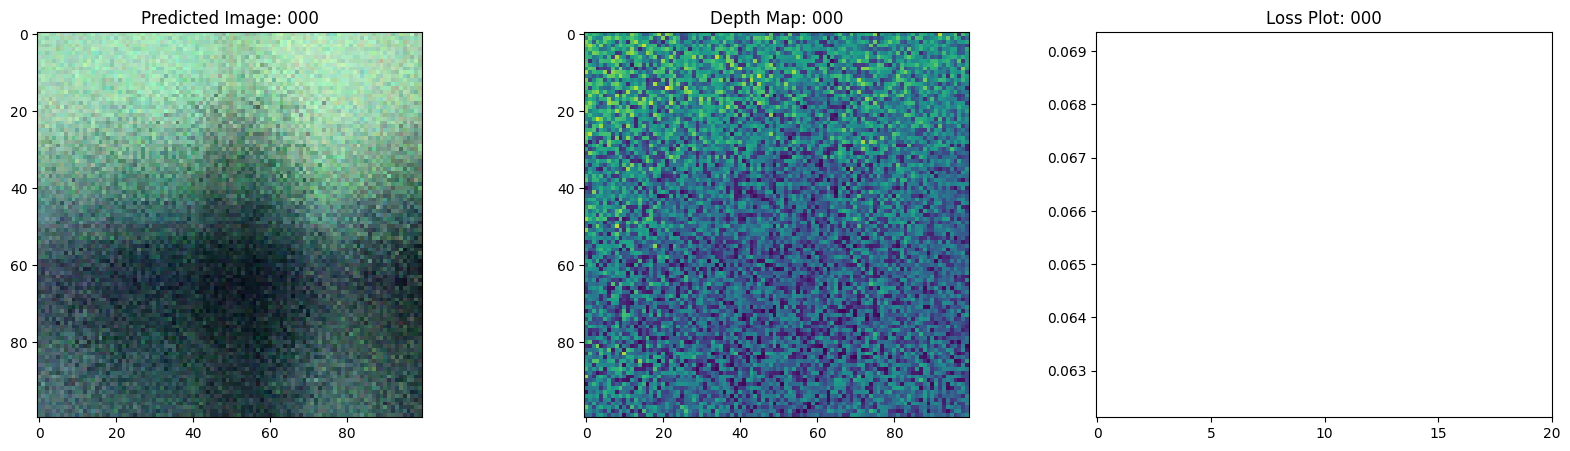

750/750 [==============================] - 41s 50ms/step - loss: 0.0657 - psnr: 12.1221


In [ ]:
model.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[TrainMonitor()],
    steps_per_epoch=split_index // BATCH_SIZE,
)
